In [ ]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.datasets import mnist
import numpy as np






In [1]:
!nvidia-smi

Tue Jul 14 11:55:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

n_samples, h, w = x_train.shape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print( x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
n_components = 2

print("Extracting the top %d eigenvector from %d images"
      % (n_components, x_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(x_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
print(eigenfaces .shape)

print("Projecting the input data")
t0 = time()
X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)
print("done in %0.3fs" % (time() - t0))
print(X_train_pca.shape)
print(X_test_pca.shape)

Extracting the top 2 eigenvector from 60000 images
done in 1.805s
(2, 28, 28)
Projecting the input data
done in 0.209s
(60000, 2)
(10000, 2)


In [ ]:
def visualize(X,y):
  plt.figure(figsize=(10, 10))
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
  plt.colorbar()
  plt.show()

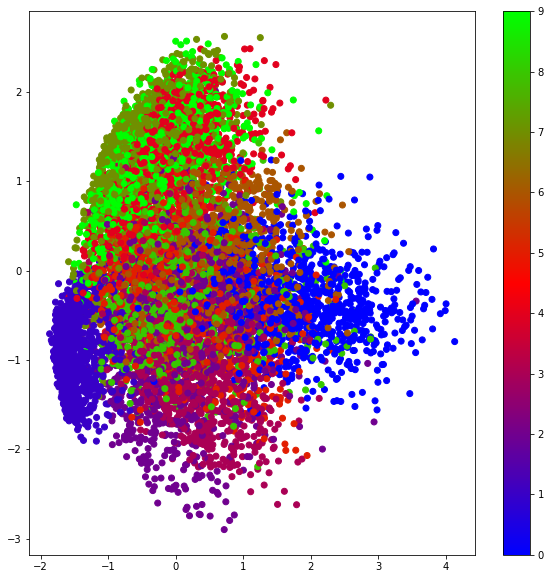

In [ ]:
visualize(X_test_pca,y_test)

**Using Auto Encoder**

In [ ]:
import keras
from keras.models import Sequential ,Model
from keras.layers import Input,Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

# *I am implementing 2 models: one with linear activation and one with non_linear activation. Choose either*

# **Basic model with linear_activation which could be similar to PCA because PCA is also kind of linear**

In [ ]:

input_dim = h*w 
encoding_dim = 2
input_img = Input(shape=(input_dim,))

In [ ]:
def Basic_model(input_img):
  encoded = Dense(encoding_dim, activation='linear')(input_img)
  decoded = Dense(784, activation='linear')(encoded)
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  print(autoencoder.summary())
  return autoencoder,encoded


# **Model for non-linear activation**

In [ ]:
def Model_non_linear(input_img):
  encoded = Dense(128, activation='relu')(input_img)
  encoded = Dense(64, activation='relu')(encoded)
  encoded = Dense(32, activation='relu')(encoded)
  encoded = Dense(2, activation='relu')(encoded)

  decoded = Dense(32, activation='relu')(encoded)
  decoded = Dense(64, activation='relu')(encoded)
  decoded = Dense(128, activation='relu')(decoded)
  decoded = Dense(784, activation='sigmoid')(decoded)
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  print(autoencoder.summary())
  return autoencoder , encoded


# Traing model

# **Visualization with linear activation**

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 1570      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/1000
54000/54000 [==============================] - 1s 23us/step - loss: 0.0712 - val_loss: 0.0603
Epoch 2/1000
54000/54000 [==============================] - 1s 20us/step - loss: 0.0590 - val_loss: 0.0581
Epoch 3/1000
54000/54000 [==============================] - 1s 19us/step - loss: 0.0581 - val_loss: 0.0575
Epoch 4/1000

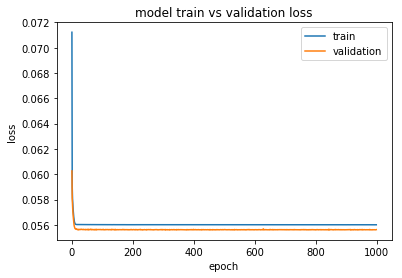

In [ ]:
autoencoder , encoded= Basic_model(input_img)  #linear activation
history = autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_split=0.1,
                verbose = 1)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))


In [ ]:

encoded_data = encoder.predict(x_test)


In [ ]:
decoded_imgs = autoencoder.predict(x_test)

In [ ]:
print(encoded_data .shape)
print(history.history['loss'][-1])

(10000, 2)
0.056003967547858205


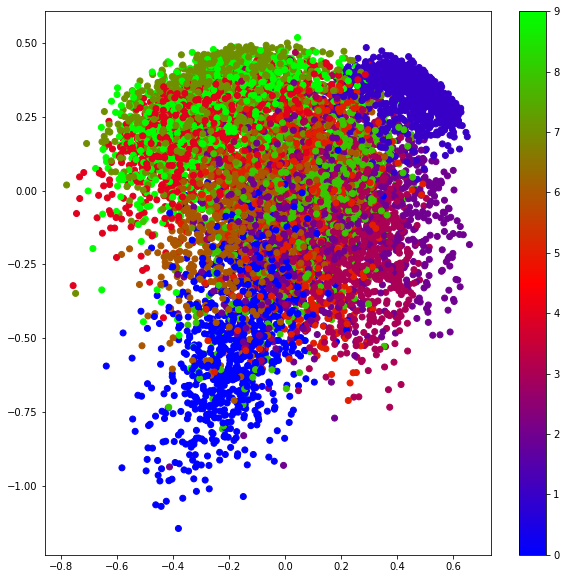

In [ ]:
visualize(encoded_data,y_test)

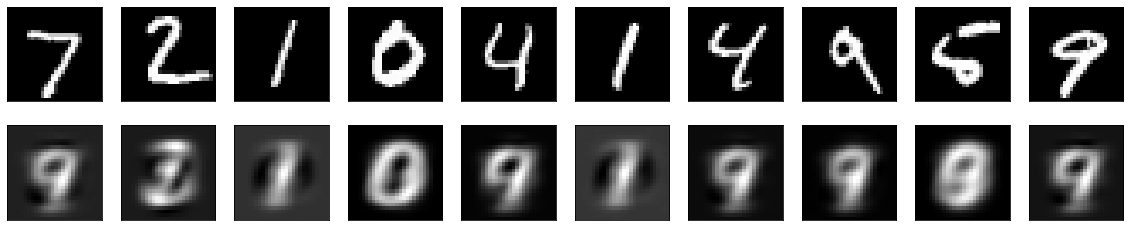

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **Visualization for non-linear activation**

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 66        
_________________________________________________________________
dense_18 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320

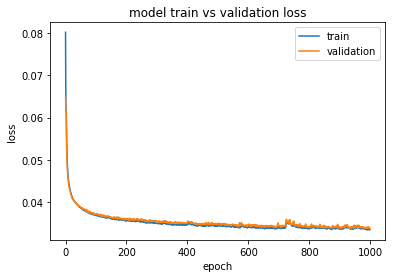

In [ ]:
autoencoder2,encoded2 = Model_non_linear(input_img)
print(autoencoder2.summary())

history2 = autoencoder2.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_split=0.1,
                verbose = 1)

#plot our loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder2 = Model(input_img, encoded2)
encoded_input = Input(shape=(encoding_dim,))


In [ ]:
encoded_data2 = encoder2.predict(x_test)
decoded_imgs2 = autoencoder2.predict(x_test)
print(encoded_data2 .shape)
print(history2.history['loss'][-1])

(10000, 2)
0.03341427723125175


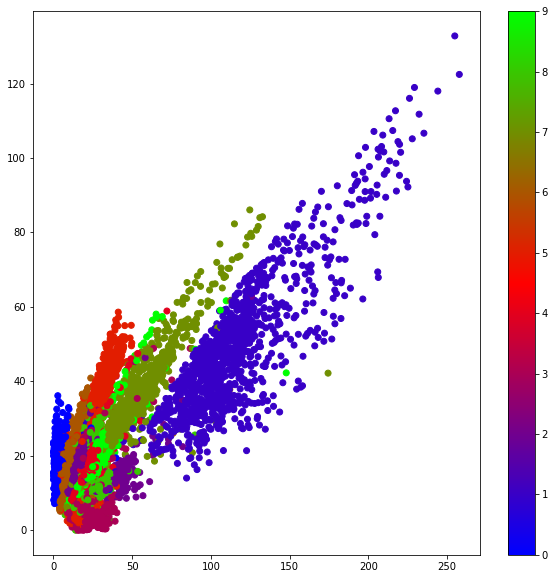

In [ ]:
visualize(encoded_data2,y_test)

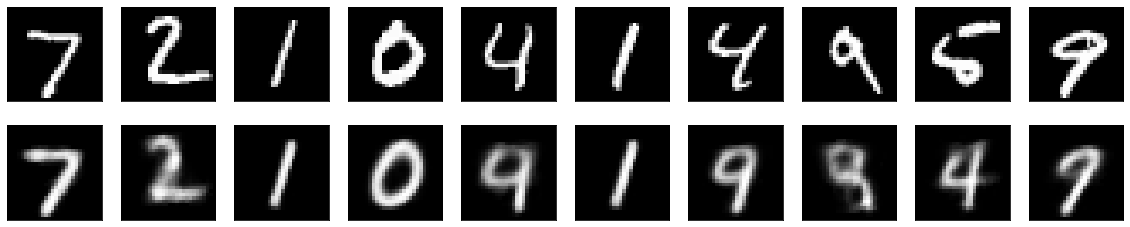

In [ ]:

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs2[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.save('basic model.h5')

In [ ]:
autoencoder2.save('non_linear_model.h5')